# Imports

In [2]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [4]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [5]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [6]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [7]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [9]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Batch Normalization

In [ ]:
# define cnn model
def define_model_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Dropout Regularization

In [ ]:
# define cnn model
def define_model_dropout_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Dropout Regularization and Batch Normalization*

In [ ]:
# define cnn model
def define_model_dropout_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [ ]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Weight Regularization and Batch Normalization

In [ ]:
# define cnn model
def define_model_weight_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [10]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data w/ Cross Validation

Epoch 1/75
94/94 [==============================] - 422s 4s/step - loss: 0.6559 - accuracy: 0.5867 - val_loss: 0.5468 - val_accuracy: 0.7352
Epoch 2/75
94/94 [==============================] - 417s 4s/step - loss: 0.5417 - accuracy: 0.7411 - val_loss: 0.5210 - val_accuracy: 0.7533
Epoch 3/75
94/94 [==============================] - 417s 4s/step - loss: 0.4829 - accuracy: 0.7868 - val_loss: 0.4407 - val_accuracy: 0.8315
Epoch 4/75
94/94 [==============================] - 417s 4s/step - loss: 0.3939 - accuracy: 0.8485 - val_loss: 0.3701 - val_accuracy: 0.8602
Epoch 5/75
94/94 [==============================] - 418s 4s/step - loss: 0.3633 - accuracy: 0.8613 - val_loss: 0.3544 - val_accuracy: 0.8625
Epoch 6/75
94/94 [==============================] - 418s 4s/step - loss: 0.3375 - accuracy: 0.8646 - val_loss: 0.3519 - val_accuracy: 0.8585
Epoch 7/75
94/94 [==============================] - 419s 4s/step - loss: 0.3213 - accuracy: 0.8713 - val_loss: 0.3255 - val_accuracy: 0.8790
Epoch 8/75
94

<AxesSubplot:title={'center':'Classification Accuracy'}>

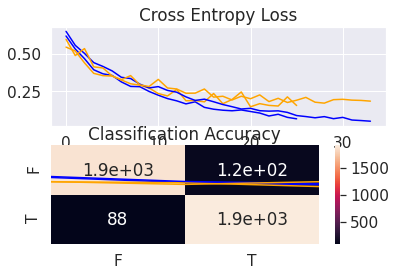

In [11]:
kf = KFold(n_splits=2)
accuracy_list = []
confusion_matrix_list = []
TPR_list, TNR_list, PPV_list, NPV_list = [], [], [], []
for tr, val in kf.split(X_all):
  X_train_cv = X_all[tr]
  X_val_cv = X_all[val]
  y_train_cv = y_all[tr]
  y_val_cv = y_all[val]
  model, accuracy = train(X_train_cv, X_val_cv, X_test, y_train_cv, y_val_cv, y_test, 0.001, 75)
  print(accuracy)
  accuracy_list.append(accuracy)
  # compute confusion matrix 
  y_pred = model.predict(X_test)
  y_pred_val = y_pred.argmax(axis=1)
  y_test_val = y_test.argmax(axis=1)
  confusion_matrix_list.append(confusion_matrix(y_test_val, y_pred_val))
  tn, fp, fn, tp = confusion_matrix_list[-1].ravel()
  # calculate tpr, tnr, ppv, and npv, and add them to the lists
  TPR_list.append(tp/(tp+fn))
  TNR_list.append(tn/(tn+fp))
  PPV_list.append(tp/(tp+fp))
  NPV_list.append(tn/(tn+fn))
  print("{} {} {} {}".format(tn, fp, fn, tp))
  print("TPR/Recall: {}".format(tp/(tp+fn)))
  print("TNR/Specificity: {}".format(tn/(tn+fp)))
  print("PPV/Precision: {}".format(tp/(tp+fp)))
  print("NPV: {}".format(tn/(tn+fn)))

# calculate mean and standard deviation for each list
accuracy_mean = np.mean(accuracy_list)
accuracy_std = np.std(accuracy_list)
TPR_mean = np.mean(TPR_list)
TPR_std = np.std(TPR_list)
TNR_mean = np.mean(TNR_list)
TNR_std = np.std(TNR_list)
PPV_mean = np.mean(PPV_list)
PPV_std = np.std(PPV_list)
NPV_mean = np.mean(NPV_list)
NPV_std = np.std(NPV_list)

# total confusion matrix summed together
confusion_matrix_comb = sum(confusion_matrix_list)
df = pd.DataFrame(confusion_matrix_comb, index = ['F', 'T'], columns = ['F', 'T'])
sn.heatmap(df, annot=True) # create a heatmap

<AxesSubplot:>

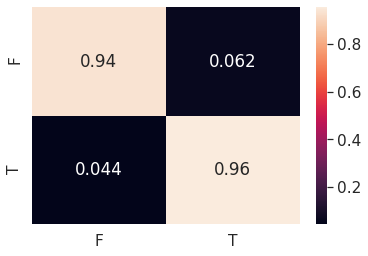

In [12]:
# normalized confusion matrix
confusion_matrix_sum = confusion_matrix_comb.astype(np.float).sum(axis=1)
confusion_matrix_norm = confusion_matrix_comb.astype(np.float)
confusion_matrix_norm[0] = confusion_matrix_norm[0] / confusion_matrix_sum[0]
confusion_matrix_norm[1] = confusion_matrix_norm[1] / confusion_matrix_sum[1]
df = pd.DataFrame(confusion_matrix_norm, index = ['F', 'T'], columns = ['F', 'T'])
sn.heatmap(df, annot=True) # create a heatmap

## Train Data with Batch Normalization

In [ ]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

## Train Data with Data Augmentation and Batch Normalization

In [ ]:
def train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

In [ ]:
model_test_data_augmentation_batch_normalization, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_augmentation_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Dropout Regularization and Batch Normalization

In [ ]:
def train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_dropout_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization and Batch Normalization

In [ ]:
def train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))